In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = 16, 12


from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.decomposition import PCA

from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

##### The Sequential Backward Selection algorithm below has been taken from:
Python Machine Learning - By Sebastian Raschka - Chapter 4

In [2]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [3]:
file = 'data/price_data.csv'
data = pd.read_csv(file)

file1 = 'data/price_data1.csv'
data1 = pd.read_csv(file1)

In [4]:
data.head(3)

,Date,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F152,F153,F154,F155,F156,F157,F158,F159,F160,F161
0,2001-11-01,-0.255573,0.843547,1.934654,3.154484,4.338643,0.721823,1.820943,2.912050,4.131880,...,0,0,0,0,0,-1,1,1,0,1
1,2001-11-02,0.450025,1.570834,2.667976,3.911019,5.127367,0.720301,1.841110,2.938253,4.181296,...,0,0,0,0,0,0,1,1,1,1
2,2001-11-05,0.806067,1.926585,3.025005,4.287761,5.534214,0.601789,1.722307,2.820726,4.083482,...,0,1,0,0,0,0,1,1,1,1


In [5]:
del data['Date']
del data1['Date']

In [6]:
data.head(3)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F152,F153,F154,F155,F156,F157,F158,F159,F160,F161
0,-0.255573,0.843547,1.934654,3.154484,4.338643,0.721823,1.820943,2.912050,4.131880,5.316038,...,0,0,0,0,0,-1,1,1,0,1
1,0.450025,1.570834,2.667976,3.911019,5.127367,0.720301,1.841110,2.938253,4.181296,5.397643,...,0,0,0,0,0,0,1,1,1,1
2,0.806067,1.926585,3.025005,4.287761,5.534214,0.601789,1.722307,2.820726,4.083482,5.329935,...,0,1,0,0,0,0,1,1,1,1


In [7]:
# Features are F1 through F42
# Labels are RET5, RET10, RET15, RET20, RET25, RET30

X = data.loc[:,'F1':'F68']
X_events = data.loc[:,'F75':'F161']
y5 = data.loc[:,'RET5']
y10 = data.loc[:,'RET10']
y15 = data.loc[:,'RET15']
y20 = data.loc[:,'RET20']
y25 = data.loc[:,'RET25']
y30 = data.loc[:,'RET30']

In [8]:
X1 = data1.loc[:,'F1':'F68']
X1_events = data1.loc[:,'F75':'F161']
yt5 = data1.loc[:,'RET5']
yt10 = data1.loc[:,'RET10']
yt15 = data1.loc[:,'RET15']
yt20 = data1.loc[:,'RET20']
yt25 = data1.loc[:,'RET25']
yt30 = data1.loc[:,'RET30']

In [10]:
X_events.head(5)

,F75,F76,F77,F78,F79,F80,F81,F82,F83,F84,...,F152,F153,F154,F155,F156,F157,F158,F159,F160,F161
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,-1,1,1,0,1
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,0,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,1,1,1


In [11]:
X.describe()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F59,F60,F61,F62,F63,F64,F65,F66,F67,F68
count,3752.000000,3752.000000,3752.000000,3752.000000,3752.000000,3752.000000,3752.000000,3752.000000,3752.000000,3752.000000,...,3752.000000,3752.000000,3752.000000,3752.000000,3752.000000,3752.000000,3752.000000,3752.000000,3752.000000,3752.000000
mean,0.050367,0.142632,0.233682,0.372955,0.574344,0.049067,0.141333,0.232382,0.371655,0.573044,...,0.392865,0.525996,-0.000212,0.000397,0.001525,0.003182,0.005828,0.005145,0.005802,0.005585
std,0.535517,1.101749,1.542153,2.135543,2.898247,0.627573,1.177573,1.606629,2.188830,2.940999,...,1.290495,1.342335,0.209454,0.096618,0.086176,0.076404,0.152416,0.063860,0.054228,0.044518
min,-4.387103,-6.259928,-7.189703,-8.286075,-8.797474,-4.849087,-6.721912,-7.452904,-8.069769,-8.990822,...,-2.822449,-2.324601,-1.270375,-0.495597,-0.404046,-0.328938,-0.673942,-0.235368,-0.174520,-0.131085
25%,-0.187494,-0.339278,-0.455629,-0.580097,-0.672569,-0.228304,-0.382978,-0.498053,-0.624482,-0.703790,...,-0.289897,-0.302808,-0.097187,-0.040086,-0.034834,-0.029706,-0.059327,-0.021625,-0.014597,-0.012293
50%,0.040992,0.117801,0.189088,0.275623,0.424599,0.041094,0.123438,0.192148,0.271378,0.413530,...,0.298916,0.209519,0.001620,0.003430,0.003901,0.006182,0.011673,0.007550,0.007068,0.008204
75%,0.281565,0.627500,0.868878,1.212973,1.564262,0.326896,0.657165,0.896850,1.222729,1.574272,...,1.009059,1.285411,0.096505,0.049610,0.048543,0.046796,0.089698,0.039022,0.029278,0.022904
max,3.018847,5.937984,8.213257,11.280604,15.174929,4.130036,6.449057,8.633410,11.623837,15.447101,...,6.400366,6.415268,1.189641,0.429626,0.334233,0.279201,0.573158,0.223113,0.210969,0.184547


When we plot histograms for each return label we can see that all the returns are approximately normally distributed aroung 0. We can also see that this stock in particular has a positive skew. This conforms with the upward bias in the stock market.

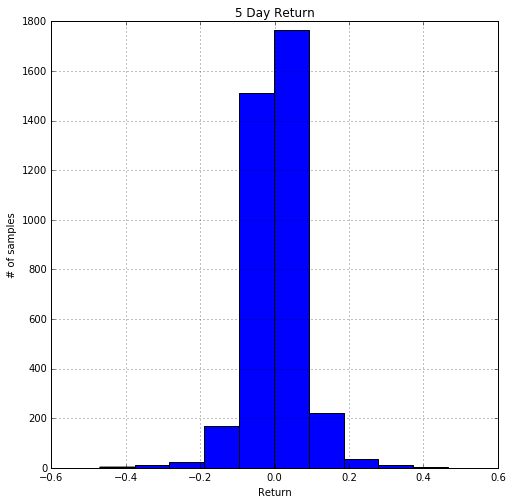

In [12]:
plt.rcParams['figure.figsize'] = 8, 8
y5.hist()
plt.xlabel('Return')
plt.ylabel('# of samples')
plt.title('5 Day Return')
plt.show()

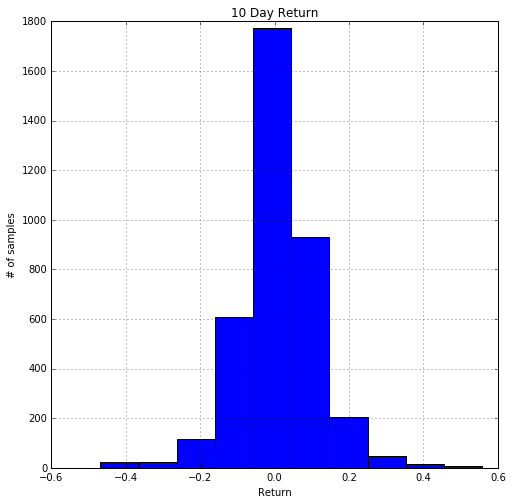

In [13]:
y10.hist()
plt.xlabel('Return')
plt.ylabel('# of samples')
plt.title('10 Day Return')
plt.show()

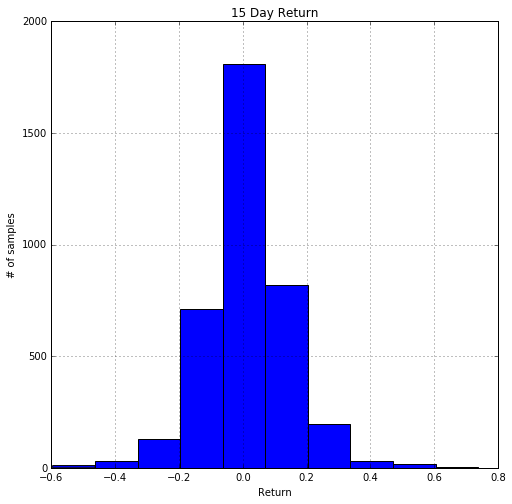

In [14]:
y15.hist()
plt.xlabel('Return')
plt.ylabel('# of samples')
plt.title('15 Day Return')
plt.show()

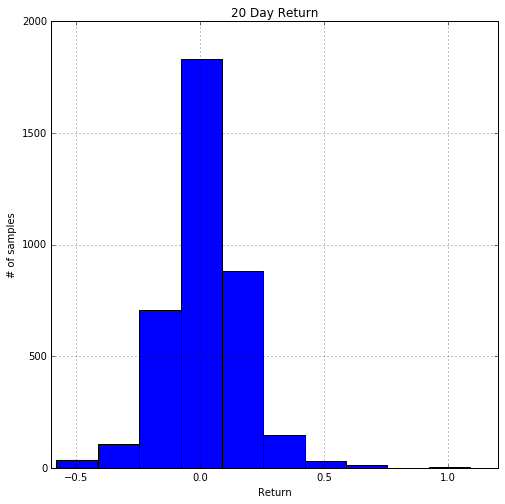

In [15]:
y20.hist()
plt.xlabel('Return')
plt.ylabel('# of samples')
plt.title('20 Day Return')
plt.show()

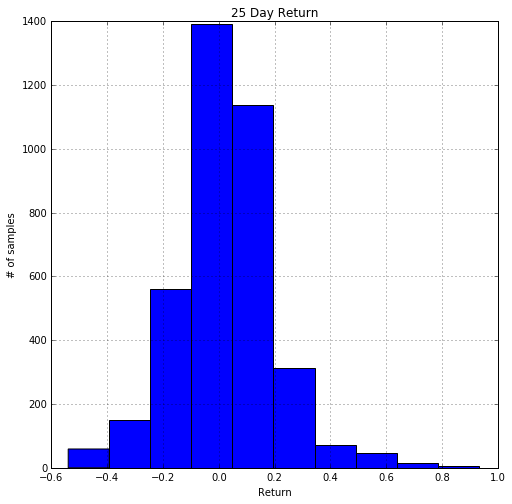

In [16]:
y25.hist()
plt.xlabel('Return')
plt.ylabel('# of samples')
plt.title('25 Day Return')
plt.show()

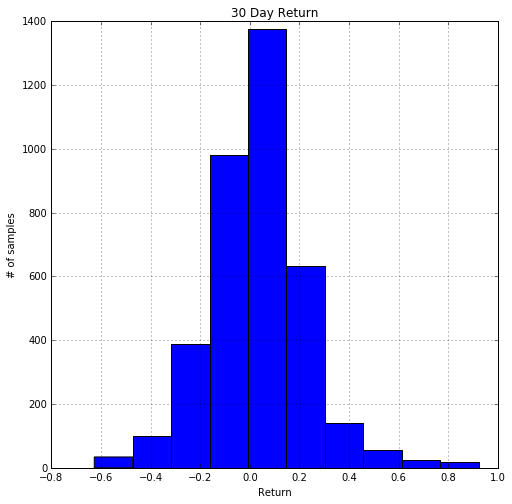

In [17]:
y30.hist()
plt.xlabel('Return')
plt.ylabel('# of samples')
plt.title('30 Day Return')
plt.show()

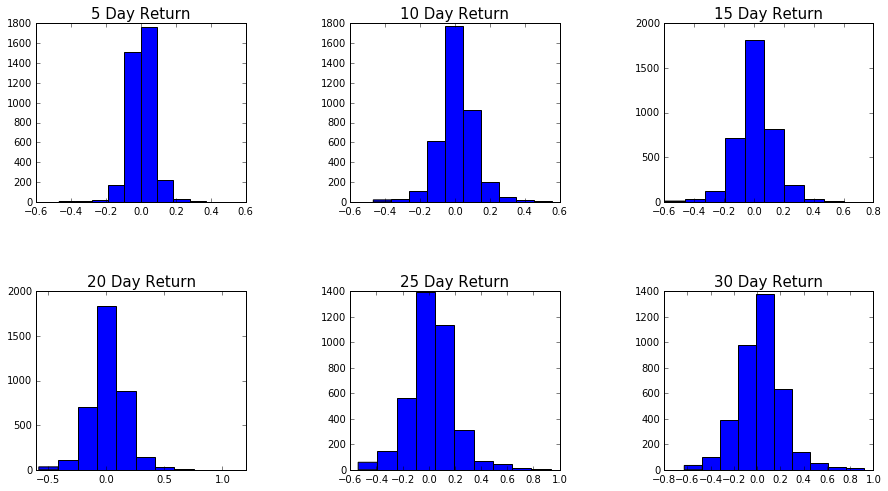

In [18]:
plt.rcParams['figure.figsize'] = 15, 8
fig, axes = plt.subplots(2,3, sharex=False, sharey=False)

axes[0,0].hist(y5)
axes[0,0].set_title('5 Day Return', fontsize=15)

axes[0,1].hist(y10)
axes[0,1].set_title('10 Day Return', fontsize=15)

axes[0,2].hist(y15)
axes[0,2].set_title('15 Day Return', fontsize=15)

axes[1,0].hist(y20)
axes[1,0].set_title('20 Day Return', fontsize=15)

axes[1,1].hist(y25)
axes[1,1].set_title('25 Day Return', fontsize=15)

axes[1,2].hist(y30)
axes[1,2].set_title('30 Day Return', fontsize=15)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

### Phase 1
In the first phase of model building we will start with the simplest label grouping. We will separate our labels into either positive, or negative returns. This will give us two classes with approximately equal class distributions.

In [19]:
y5.columns = ['RET']
y10.columns = ['RET']
y15.columns = ['RET']
y20.columns = ['RET']
y25.columns = ['RET']
y30.columns = ['RET']

In [20]:
def binary_class(row):
    if row < 0.00:
        return 0
    else:
        return 1

In [21]:
y5_b = pd.Series(index=y5.index)
y10_b = pd.Series(index=y5.index)
y15_b = pd.Series(index=y5.index)
y20_b = pd.Series(index=y5.index)
y25_b = pd.Series(index=y5.index)
y30_b = pd.Series(index=y5.index)

y5_b = y5.apply(binary_class)
y10_b = y10.apply(binary_class)
y15_b = y15.apply(binary_class)
y20_b = y20.apply(binary_class)
y25_b = y25.apply(binary_class)
y30_b = y30.apply(binary_class)

In [22]:
yt5.columns = ['RET']
yt10.columns = ['RET']
yt15.columns = ['RET']
yt20.columns = ['RET']
yt25.columns = ['RET']
yt30.columns = ['RET']

yt5_b = pd.Series(index=yt5.index)
yt10_b = pd.Series(index=yt5.index)
yt15_b = pd.Series(index=yt5.index)
yt20_b = pd.Series(index=yt5.index)
yt25_b = pd.Series(index=yt5.index)
yt30_b = pd.Series(index=yt5.index)

yt5_b = yt5.apply(binary_class)
yt10_b = yt10.apply(binary_class)
yt15_b = yt15.apply(binary_class)
yt20_b = yt20.apply(binary_class)
yt25_b = yt25.apply(binary_class)
yt30_b = yt30.apply(binary_class)

In [23]:
plt.rcParams['figure.figsize'] = 8, 8

Looking at the binary classification results, we can see that separating the class labels based on negative and positive returns, gives us an approximately equal distribution for each class.

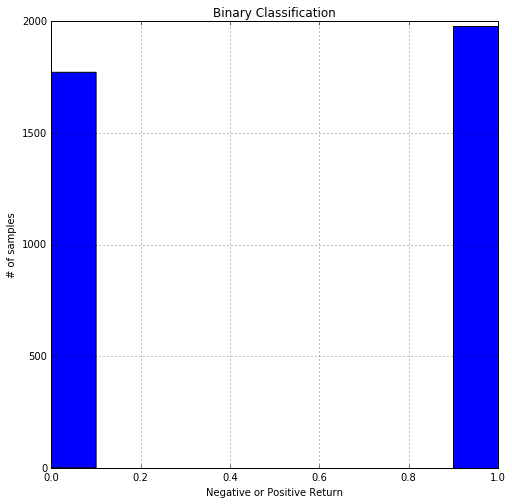

In [24]:
y5_b.hist()
plt.xlabel('Negative or Positive Return')
plt.ylabel('# of samples')
plt.title('Binary Classification')
plt.show()

### Phase 2
In this phase we will increase the number of boundaries from one to two. From a trading standpoint, we want to stay away from trades that return close to 0% return. We do want to identify trades that have substantial return.

We can define substantial return as > 2% or 0.02 or < -2% or -0.02
Class boundaries:
label 0: <=-0.02
label 1: >-0.02 and < 0.02
label 2: >= 0.02

Another way to find out what the boundary should be is to look at the class distributions that result from a particular boundary. The boundary can then be changed to ensure that the distribution becomes approximately equal for all classes. You may find that you have to use different boundaries for different returns.

In [25]:
def update_return_class(row, neg_cutoff, pos_cutoff):
    if row <= neg_cutoff:
        return 0
    elif row > neg_cutoff and row < pos_cutoff:
        return 1
    elif row >= pos_cutoff:
        return 2

In [26]:
y5_t = pd.Series(index=y5.index)
y10_t = pd.Series(index=y5.index)
y15_t = pd.Series(index=y5.index)
y20_t = pd.Series(index=y5.index)
y25_t = pd.Series(index=y5.index)
y30_t = pd.Series(index=y5.index)

y5_t = y5.apply(update_return_class, args=(-0.02, 0.02))
y10_t = y10.apply(update_return_class, args=(-0.03, 0.03))
y15_t = y15.apply(update_return_class, args=(-0.05, 0.05))
y20_t = y20.apply(update_return_class, args=(-0.05, 0.05))
y25_t = y25.apply(update_return_class, args=(-0.05, 0.07))
y30_t = y30.apply(update_return_class, args=(-0.05, 0.08))

In [27]:
yt5_t = pd.Series(index=yt5.index)
yt10_t = pd.Series(index=yt5.index)
yt15_t = pd.Series(index=yt5.index)
yt20_t = pd.Series(index=yt5.index)
yt25_t = pd.Series(index=yt5.index)
yt30_t = pd.Series(index=yt5.index)

yt5_t = yt5.apply(update_return_class, args=(-0.02, 0.02))
yt10_t = yt10.apply(update_return_class, args=(-0.03, 0.03))
yt15_t = yt15.apply(update_return_class, args=(-0.05, 0.05))
yt20_t = yt20.apply(update_return_class, args=(-0.05, 0.05))
yt25_t = yt25.apply(update_return_class, args=(-0.05, 0.07))
yt30_t = yt30.apply(update_return_class, args=(-0.05, 0.08))

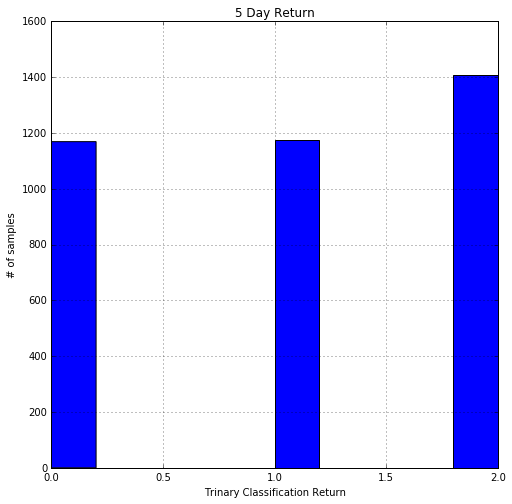

In [28]:
y5_t.hist()
plt.xlabel('Trinary Classification Return')
plt.ylabel('# of samples')
plt.title('5 Day Return')
plt.show()

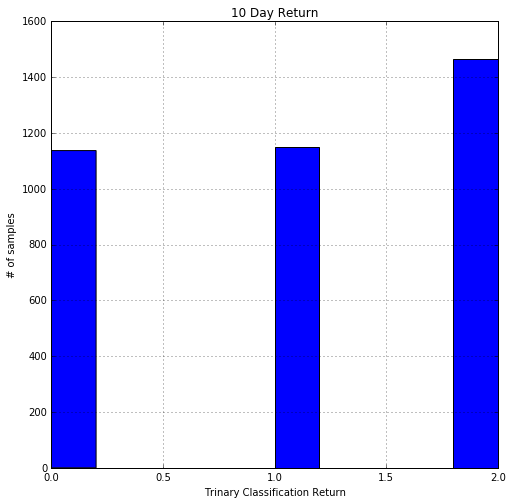

In [29]:
y10_t.hist()
plt.xlabel('Trinary Classification Return')
plt.ylabel('# of samples')
plt.title('10 Day Return')
plt.show()

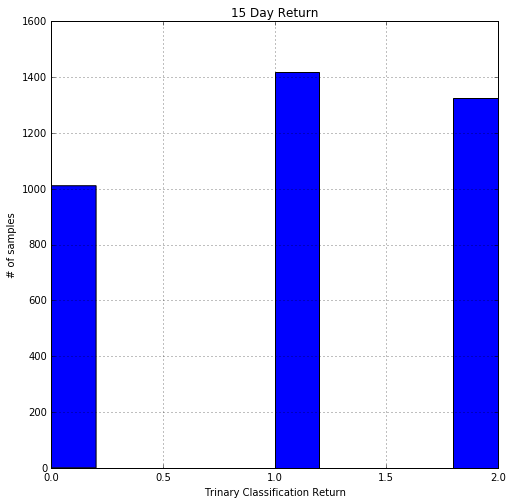

In [30]:
y15_t.hist()
plt.xlabel('Trinary Classification Return')
plt.ylabel('# of samples')
plt.title('15 Day Return')
plt.show()

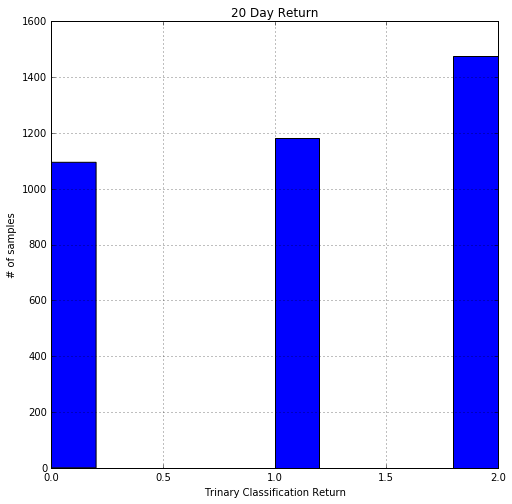

In [31]:
y20_t.hist()
plt.xlabel('Trinary Classification Return')
plt.ylabel('# of samples')
plt.title('20 Day Return')
plt.show()

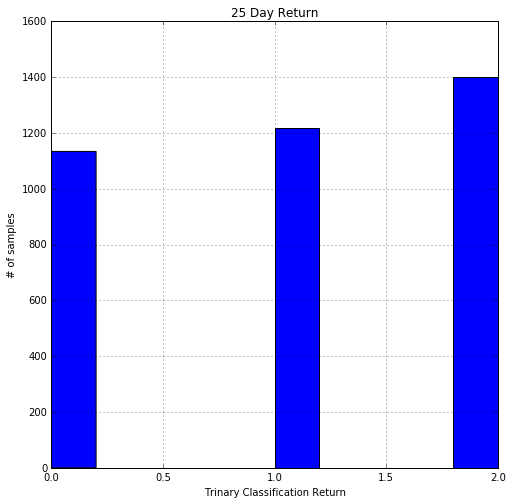

In [32]:
y25_t.hist()
plt.xlabel('Trinary Classification Return')
plt.ylabel('# of samples')
plt.title('25 Day Return')
plt.show()

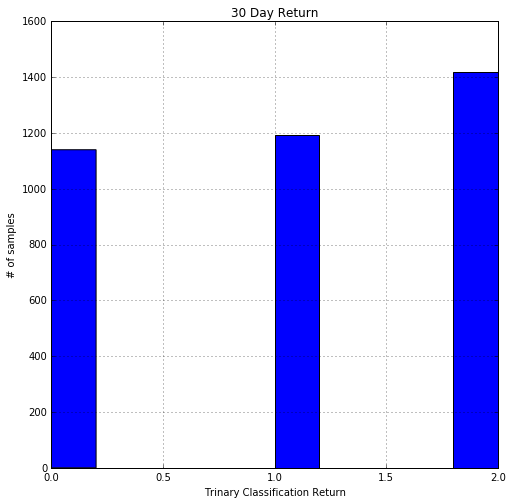

In [33]:
y30_t.hist()
plt.xlabel('Trinary Classification Return')
plt.ylabel('# of samples')
plt.title('30 Day Return')
plt.show()

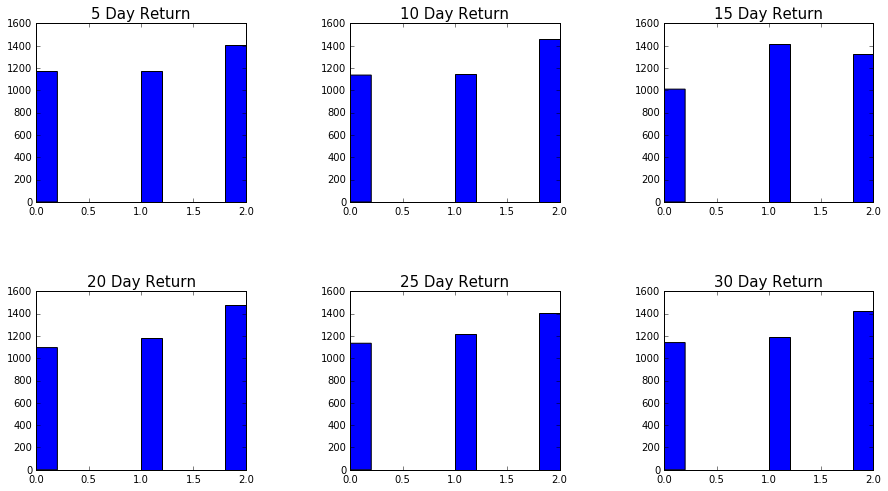

In [34]:
plt.rcParams['figure.figsize'] = 15, 8
fig, axes = plt.subplots(2,3, sharex=False, sharey=False)

axes[0,0].hist(y5_t)
axes[0,0].set_title('5 Day Return', fontsize=15)

axes[0,1].hist(y10_t)
axes[0,1].set_title('10 Day Return', fontsize=15)

axes[0,2].hist(y15_t)
axes[0,2].set_title('15 Day Return', fontsize=15)

axes[1,0].hist(y20_t)
axes[1,0].set_title('20 Day Return', fontsize=15)

axes[1,1].hist(y25_t)
axes[1,1].set_title('25 Day Return', fontsize=15)

axes[1,2].hist(y30_t)
axes[1,2].set_title('30 Day Return', fontsize=15)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

### Testing and Validation Strategy
We will be using multi-pronged testing strategy
1) Use k-fold cross-validation
2) Use continuous samples as training data and test on future data
3) Use sliding window continuous training and test data

In [141]:
validation_size = 0.20
seed = 7

#X = data.loc[:,'F1':'F68']
#X = data.loc[:,['F20','F22','F26','F29','F30','F32','F35','F36','F37','F38','F39','F40','F41','F42']]
#X = data.loc[:,['F20','F22','F35','F36','F37','F38','F39','F40','F41','F42','F46','F47','F51','F52']]
#X = data.loc[:,['F19','F20','F37','F38','F39','F40','F41','F42','F46','F47','F52','F54','F55','F56','F57','F58','F59','F60','F64','F66','F67','F68']]
#X = data.loc[:,['F19','F20','F35','F36','F37','F38','F39','F40','F41','F42','F46','F47','F52','F54','F55','F56','F57','F58','F59','F60','F61','F62','F63','F64','F65','F66','F67','F68']]
#X = data.loc[:,['F19','F35','F36','F37','F38','F39','F40','F41','F46','F47','F52','F54','F55','F56','F57','F58','F59','F61','F62','F63','F64','F65','F66','F67']]

X = X_events.loc[:,'F75':'F161']
X = X_events.loc[:,['F161','F124','F105','F139','F111','F110','F123','F115','F131','F98','F94','F158','F103','F106','F140','F126','F83','F157','F148','F114','F137','F93','F160','F78','F153','F147','F127','F130','F79','F116','F82','F101','F102','F112','F104','F86']]
X5b_train, X5b_test, Y5b_train, Y5b_test = cross_validation.train_test_split(X, y5_b, test_size=validation_size, 
                                                                                 random_state=seed)
X10b_train, X10b_test, Y10b_train, Y10b_test = cross_validation.train_test_split(X, y10_b, test_size=validation_size, 
                                                                                 random_state=seed)
X15b_train, X15b_test, Y15b_train, Y15b_test = cross_validation.train_test_split(X, y15_b, test_size=validation_size, 
                                                                                 random_state=seed)
X20b_train, X20b_test, Y20b_train, Y20b_test = cross_validation.train_test_split(X, y20_b, test_size=validation_size, 
                                                                                 random_state=seed)
X25b_train, X25b_test, Y25b_train, Y25b_test = cross_validation.train_test_split(X, y25_b, test_size=validation_size, 
                                                                                 random_state=seed)
X30b_train, X30b_test, Y30b_train, Y30b_test = cross_validation.train_test_split(X, y30_b, test_size=validation_size, 
                                                                                 random_state=seed)

X5t_train, X5t_test, Y5t_train, Y5t_test = cross_validation.train_test_split(X, y5_t, test_size=validation_size, 
                                                                                 random_state=seed)
X10t_train, X10t_test, Y10t_train, Y10t_test = cross_validation.train_test_split(X, y10_t, test_size=validation_size, 
                                                                                 random_state=seed)
X15t_train, X15t_test, Y15t_train, Y15t_test = cross_validation.train_test_split(X, y15_t, test_size=validation_size, 
                                                                                 random_state=seed)
X20t_train, X20t_test, Y20t_train, Y20t_test = cross_validation.train_test_split(X, y20_t, test_size=validation_size, 
                                                                                 random_state=seed)
X25t_train, X25t_test, Y25t_train, Y25t_test = cross_validation.train_test_split(X, y25_t, test_size=validation_size, 
                                                                                 random_state=seed)
X30t_train, X30t_test, Y30t_train, Y30t_test = cross_validation.train_test_split(X, y30_t, test_size=validation_size, 
                                                                                 random_state=seed)

In [142]:
X.head()

,F161,F124,F105,F139,F111,F110,F123,F115,F131,F98,...,F127,F130,F79,F116,F82,F101,F102,F112,F104,F86
0,1,0,-1,0,1,1,0,-1,0,1,...,0,0,1,-1,1,1,1,-1,1,1
1,1,0,-1,0,1,1,0,-1,0,1,...,0,0,1,-1,1,1,1,-1,1,1
2,1,0,-1,0,1,1,0,-1,0,1,...,0,0,1,-1,1,1,1,1,1,1
3,1,0,-1,0,1,1,0,1,0,1,...,0,0,1,-1,1,1,1,1,1,1
4,1,0,-1,0,1,1,0,1,0,1,...,0,0,1,-1,1,1,1,1,1,1


In [143]:
# Evaluate Algorithms
# Test options and evaluation metric
num_folds = 10
num_instances = len(X10b_train)
seed = 7
scoring = 'accuracy'

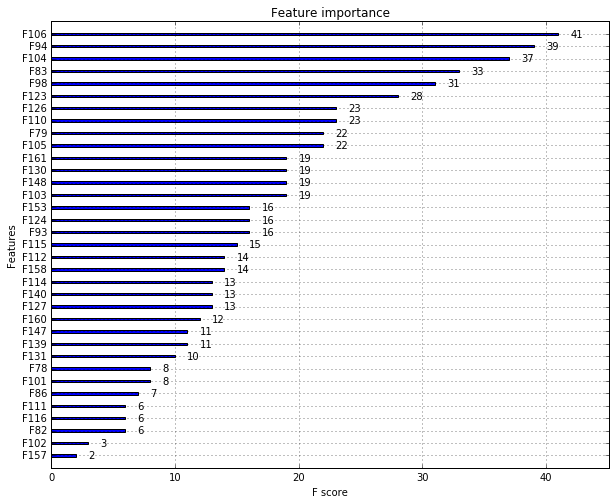

In [144]:
xgb = XGBClassifier()
xgb.fit(X25b_train, Y25b_train)
Y_pred = xgb.predict(X25b_test)
plot_importance(xgb)
plt.show()

In [145]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier(n_estimators=250, max_depth=25, min_samples_split=10, min_samples_leaf=10)
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
lr = LogisticRegression()
lda = LinearDiscriminantAnalysis()

stdsc5b = MinMaxScaler()
stdsc10b = MinMaxScaler()
stdsc15b = MinMaxScaler()
stdsc20b = MinMaxScaler()
stdsc25b = MinMaxScaler()
stdsc30b = MinMaxScaler()

X5b_train_std = stdsc5b.fit_transform(X5b_train)
X5b_test_std = stdsc5b.transform(X5b_test)

X10b_train_std = stdsc10b.fit_transform(X10b_train)
X10b_test_std = stdsc10b.transform(X10b_test)

X15b_train_std = stdsc15b.fit_transform(X15b_train)
X15b_test_std = stdsc15b.transform(X15b_test)

X20b_train_std = stdsc20b.fit_transform(X20b_train)
X20b_test_std = stdsc20b.transform(X20b_test)

X25b_train_std = stdsc25b.fit_transform(X25b_train)
X25b_test_std = stdsc25b.transform(X25b_test)

X30b_train_std = stdsc30b.fit_transform(X30b_train)
X30b_test_std = stdsc30b.transform(X30b_test)

stdsc5t = MinMaxScaler()
stdsc10t = MinMaxScaler()
stdsc15t = MinMaxScaler()
stdsc20t = MinMaxScaler()
stdsc25t = MinMaxScaler()
stdsc30t = MinMaxScaler()

X5t_train_std = stdsc5t.fit_transform(X5t_train)
X5t_test_std = stdsc5t.transform(X5t_test)

X10t_train_std = stdsc10t.fit_transform(X10t_train)
X10t_test_std = stdsc10t.transform(X10t_test)

X15t_train_std = stdsc15t.fit_transform(X15t_train)
X15t_test_std = stdsc15t.transform(X15t_test)

X20t_train_std = stdsc20t.fit_transform(X20t_train)
X20t_test_std = stdsc20t.transform(X20t_test)

X25t_train_std = stdsc25t.fit_transform(X25t_train)
X25t_test_std = stdsc25t.transform(X25t_test)

X30t_train_std = stdsc30t.fit_transform(X30t_train)
X30t_test_std = stdsc30t.transform(X30t_test)

In [155]:
X_train = X25b_train_std
y_train = Y25b_train
rfecv = RFECV(estimator=et, step=1, cv=StratifiedKFold(y_train, n_folds=10, random_state=seed), scoring='accuracy')
rfecv.fit(X_train,y_train)
rfe = RFE(estimator=et, step=1)
rfe.fit(X_train,y_train)

RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=25, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=10, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
  estimator_params=None, n_features_to_select=None, step=1, verbose=0)

In [156]:
print('# of selected features with CV: %i' %rfecv.n_features_)
print('Mask of selected features with CV: %s' %rfecv.support_)
print('Selected features ranking: %s' %rfecv.ranking_)
print('CV scores: %s' %rfecv.grid_scores_)

# of selected features with CV: 21
Mask of selected features with CV: [ True False  True False  True  True False False False  True  True  True
  True  True False False  True False False False False  True  True  True
 False False False False  True  True  True  True  True  True  True  True]
Selected features ranking: [ 1  7  1 15  1  1  5  2 12  1  1  1  1  1 16  4  1  9  8  3 13  1  1  1 14
 10 11  6  1  1  1  1  1  1  1  1]
CV scores: [ 0.56447884  0.59648905  0.60315242  0.61347586  0.61647256  0.61546485
  0.64580171  0.64881288  0.65747405  0.67048076  0.67149522  0.67015636
  0.66479852  0.67111412  0.67178082  0.68011087  0.68144199  0.67777418
  0.68011641  0.6811153   0.68178642  0.67111301  0.67778528  0.67644749
  0.67944642  0.6807842   0.67744305  0.67544526  0.67778196  0.67578193
  0.67411858  0.68178309  0.67312191  0.67545525  0.67545746  0.67745085]


In [157]:
print('Original number of features is %s' % X.shape[1])
print("RFE final number of features : %d" % rfe.n_features_)
print("RFECV final number of features : %d" % rfecv.n_features_)
print('')

import numpy as np
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print('Printing RFECV results:')
for f in range(X.shape[1]):
    print("%d. Number of features: %d; Grid_Score: %f" % (f + 1, indices[f]+1, g_scores[indices[f]]))

Original number of features is 36
RFE final number of features : 18
RFECV final number of features : 21

Printing RFECV results:
1. Number of features: 21; Grid_Score: 0.681786
2. Number of features: 32; Grid_Score: 0.681783
3. Number of features: 17; Grid_Score: 0.681442
4. Number of features: 20; Grid_Score: 0.681115
5. Number of features: 26; Grid_Score: 0.680784
6. Number of features: 19; Grid_Score: 0.680116
7. Number of features: 16; Grid_Score: 0.680111
8. Number of features: 25; Grid_Score: 0.679446
9. Number of features: 23; Grid_Score: 0.677785
10. Number of features: 29; Grid_Score: 0.677782
11. Number of features: 18; Grid_Score: 0.677774
12. Number of features: 36; Grid_Score: 0.677451
13. Number of features: 27; Grid_Score: 0.677443
14. Number of features: 24; Grid_Score: 0.676447
15. Number of features: 30; Grid_Score: 0.675782
16. Number of features: 35; Grid_Score: 0.675457
17. Number of features: 34; Grid_Score: 0.675455
18. Number of features: 28; Grid_Score: 0.67544

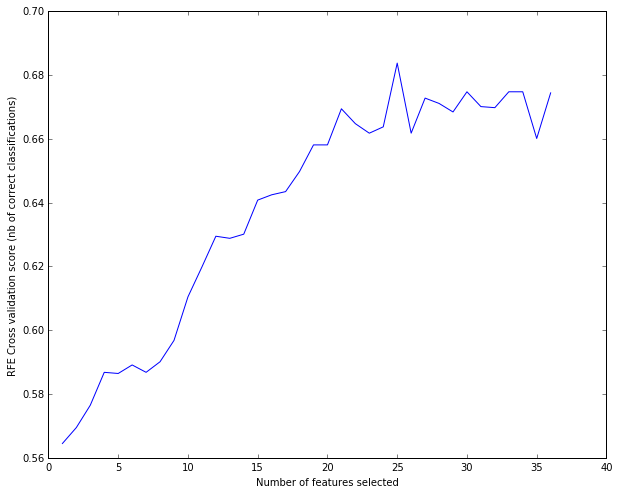

In [149]:
plt.rcParams['figure.figsize'] = 10, 8
plt.xlabel("Number of features selected")
plt.ylabel("RFE Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [150]:
print(rfecv.ranking_)

[ 1  7  1 11  1  1  1  1  8  1  1  1  1  1 12  4  1  1  1  2 10  1  1  1  9
  1  1  6  1  1  3  5  1  1  1  1]


In [151]:
print(rfecv.support_)

[ True False  True False  True  True  True  True False  True  True  True
  True  True False False  True  True  True False False  True  True  True
 False  True  True False  True  True False False  True  True  True  True]


In [152]:
print(rfecv.n_features_)

25


In [153]:
for selected, feature in zip(rfecv.support_, X.columns):
    if selected == True:
        print(feature)

F161
F105
F111
F110
F123
F115
F98
F94
F158
F103
F106
F83
F157
F148
F93
F160
F78
F147
F127
F79
F116
F102
F112
F104
F86


Original number of features is 24
RFECV final number of features : 18

Printing RFECV results:
1. Number of features: 18; Grid_Score: 0.748651
2. Number of features: 17; Grid_Score: 0.747989
3. Number of features: 19; Grid_Score: 0.746339
4. Number of features: 16; Grid_Score: 0.746327
5. Number of features: 20; Grid_Score: 0.744022
6. Number of features: 21; Grid_Score: 0.742022
7. Number of features: 22; Grid_Score: 0.741046
8. Number of features: 23; Grid_Score: 0.736396
9. Number of features: 24; Grid_Score: 0.735080
10. Number of features: 9; Grid_Score: 0.727744
11. Number of features: 13; Grid_Score: 0.726774
12. Number of features: 14; Grid_Score: 0.725095
13. Number of features: 10; Grid_Score: 0.725093
14. Number of features: 15; Grid_Score: 0.724106
15. Number of features: 11; Grid_Score: 0.722107
16. Number of features: 12; Grid_Score: 0.721106
17. Number of features: 4; Grid_Score: 0.698558
18. Number of features: 5; Grid_Score: 0.694220
19. Number of features: 7; Grid_Sco

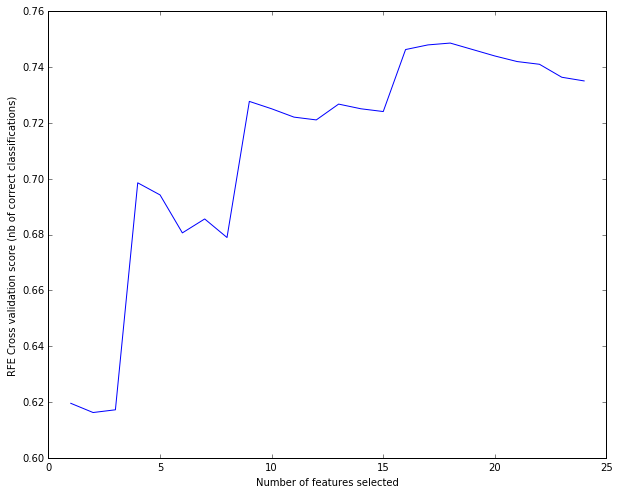

F19
F36
F37
F38
F39
F40
F41
F46
F47
F52
F54
F55
F56
F57
F58
F59
F66
F67


In [154]:
stdsct10b = MinMaxScaler()
stdsct10t = MinMaxScaler()

et1 = ExtraTreesClassifier(n_estimators=250, max_depth=25, min_samples_split=10, min_samples_leaf=10)

#X1 = data1.loc[:,['F20','F22','F26','F29','F30','F32','F35','F36','F37','F38','F39','F40','F41','F42']]
X1 = data1.loc[:,['F19','F35','F36','F37','F38','F39','F40','F41','F46','F47','F52','F54','F55','F56','F57','F58','F59','F61','F62','F63','F64','F65','F66','F67']]

Xt10b_train, Xt10b_test, Yt10b_train, Yt10b_test = cross_validation.train_test_split(X1, yt10_b, test_size=validation_size,random_state=seed)

Xt10t_train, Xt10t_test, Yt10t_train, Yt10t_test = cross_validation.train_test_split(X1, yt10_t, test_size=validation_size, random_state=seed)

Xt15t_train, Xt15t_test, Yt15t_train, Yt15t_test = cross_validation.train_test_split(X1, yt15_t, test_size=validation_size, random_state=seed)

Xt20t_train, Xt20t_test, Yt20t_train, Yt20t_test = cross_validation.train_test_split(X1, yt20_t, test_size=validation_size, random_state=seed)

Xt10b_std = stdsc10b.fit_transform(Xt10b_train)
Xt10t_std = stdsc10t.fit_transform(Xt10t_train)
Xt15t_std = stdsc15t.fit_transform(Xt15t_train)
Xt20t_std = stdsc20t.fit_transform(Xt20t_train)

xtrain = Xt20t_std
ytrain = Yt20t_train

#yt10_b
rfecv1 = RFECV(estimator=et1, step=1, cv=StratifiedKFold(ytrain, n_folds=10, random_state=seed), scoring='accuracy')
#rfecv1.fit(X110b,yt10_t)
rfecv1.fit(xtrain,ytrain)
#rfecv1.fit(X10t_train_std,Y10t_train)

print('Original number of features is %s' % X1.shape[1])
#print("RFE final number of features : %d" % rfe.n_features_)
print("RFECV final number of features : %d" % rfecv1.n_features_)
print('')

import numpy as np
g_scores = rfecv1.grid_scores_
indices = np.argsort(g_scores)[::-1]
print('Printing RFECV results:')
for f in range(X1.shape[1]):
    print("%d. Number of features: %d; Grid_Score: %f" % (f + 1, indices[f]+1, g_scores[indices[f]]))

plt.rcParams['figure.figsize'] = 10, 8
plt.xlabel("Number of features selected")
plt.ylabel("RFE Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv1.grid_scores_) + 1), rfecv1.grid_scores_)
plt.show()


for selected, feature in zip(rfecv1.support_, X1.columns):
    if selected == True:
        print(feature)

In [63]:
# ensembles
ensembles = []
#ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostClassifier())])))
#ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier())])))
#ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])))
#ensembles.append(('mmScaledRF', Pipeline([('mmScaler', MinMaxScaler(feature_range=(-1,1))),('RF', RandomForestClassifier(n_estimators=250, max_depth=10))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesClassifier())])))
ensembles.append(('mmScaledET', Pipeline([('mmScaler', MinMaxScaler(feature_range=(0,1))),('mmET', ExtraTreesClassifier(n_estimators=250, max_depth=15))])))
results = []
names = []
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
for name, model in ensembles:
    cv_results = cross_validation.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledET: 0.808081 (0.016495)
mmScaledET: 0.794276 (0.019427)


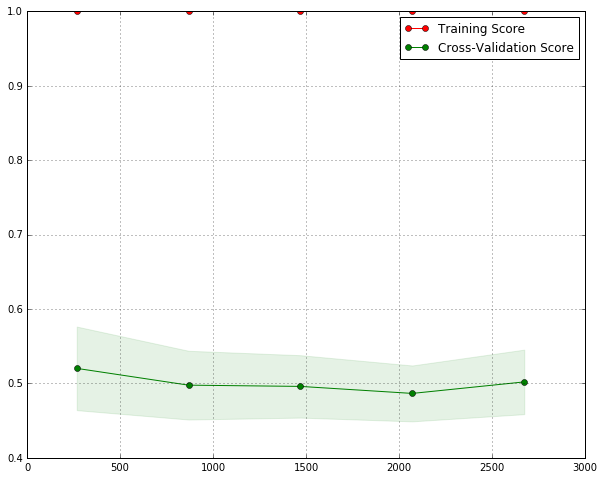

In [54]:
plt.figure()
model = Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesClassifier())])
train_sizes, train_scores, test_scores = learning_curve(model, X, y5_b, cv=kfold, n_jobs=1, train_sizes=np.linspace(.1,1.0,5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
plt.legend(loc="best")
plt.show()

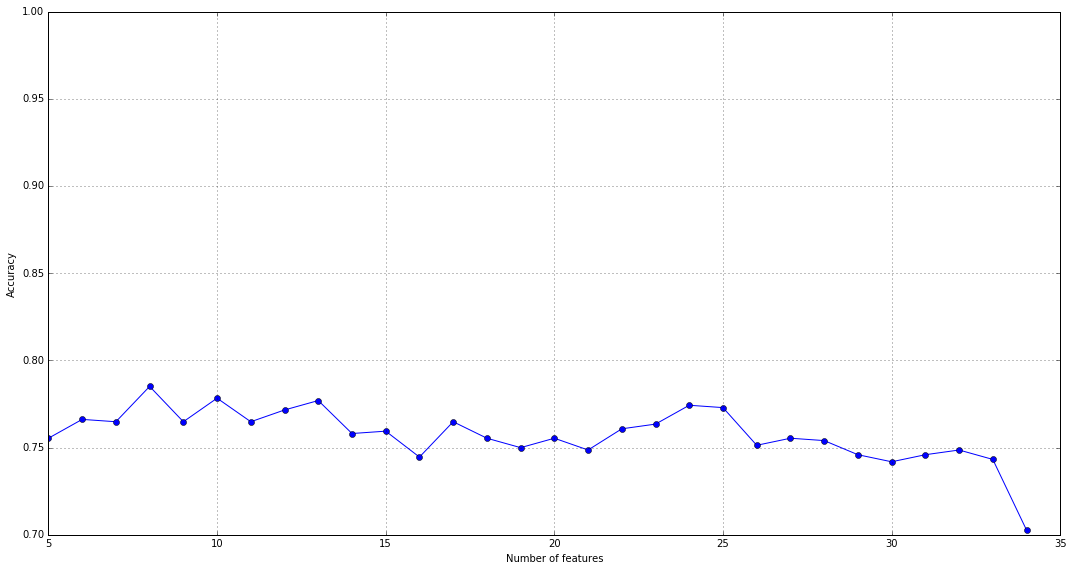

In [42]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X10b_train)
X_test_std = stdsc.transform(X10b_validation)
    
et = ExtraTreesClassifier()

# selecting features
sbs = SBS(et, k_features=5)
sbs.fit(X_train_std, Y10b_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.0])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [179]:
k5 = list(sbs.subsets_[10])
print(X10b_train_std.columns[1:][k5])
#print(k5)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [43]:
et.fit(X10b_train_std, Y10b_train)
print('Training accuracy:', et.score(X10b_train_std, Y10b_train))
print('Test accuracy:', et.score(X10b_test_std, Y10b_validation))

Training accuracy: 1.0
Test accuracy: 0.743243243243


In [44]:
et.fit(X10b_train_std[:, k5], Y10b_train)
print('Training accuracy:', et.score(X10b_train_std[:, k5], Y10b_train))
print('Test accuracy:', et.score(X10b_test_std[:, k5], Y10b_validation))

NameError: name 'k5' is not defined